In [1]:
# Dataset Label Analysis and Visualization
# Comprehensive analysis of YOLO dataset labels with statistics and visualizations

import os
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pandas as pd

DATASET_DIR = '/home/ut-ai/ai-works/adaptibot/yolo_detect/dataset'
SPLITS = ['train', 'val']
CLASS_NAMES = ['any/unknown','can','duck','cup','sponge','ball','vegetable']

print("Dataset Label Analysis")
print("=" * 50)



Dataset Label Analysis


In [2]:
# 1. Dataset Overview Statistics
print("1. DATASET OVERVIEW")
print("-" * 30)

def analyze_dataset():
    stats = {}
    
    for split in SPLITS:
        im_dir = os.path.join(DATASET_DIR, 'images', split)
        lbl_dir = os.path.join(DATASET_DIR, 'labels', split)
        
        # Count images and label files
        images = glob.glob(os.path.join(im_dir, '*.png'))
        label_files = glob.glob(os.path.join(lbl_dir, '*.txt'))
        
        stats[split] = {
            'num_images': len(images),
            'num_label_files': len(label_files),
            'class_counts': Counter(),
            'images_per_class': defaultdict(set),
            'objects_per_image': [],
            'empty_images': 0
        }
        
        # Analyze each label file
        for lbl_path in label_files:
            with open(lbl_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            if not lines:
                stats[split]['empty_images'] += 1
                stats[split]['objects_per_image'].append(0)
            else:
                stats[split]['objects_per_image'].append(len(lines))
                
                for line in lines:
                    cls_id = int(line.split()[0])
                    stats[split]['class_counts'][cls_id] += 1
                    
                    # Track which images contain each class
                    img_name = os.path.basename(lbl_path).replace('.txt', '')
                    stats[split]['images_per_class'][cls_id].add(img_name)
        
        print(f"\n{split.upper()} Split:")
        print(f"  Images: {stats[split]['num_images']}")
        print(f"  Label files: {stats[split]['num_label_files']}")
        print(f"  Empty images: {stats[split]['empty_images']}")
        print(f"  Avg objects per image: {np.mean(stats[split]['objects_per_image']):.1f}")
        print(f"  Max objects per image: {max(stats[split]['objects_per_image']) if stats[split]['objects_per_image'] else 0}")
        
    return stats

dataset_stats = analyze_dataset()


1. DATASET OVERVIEW
------------------------------

TRAIN Split:
  Images: 1815
  Label files: 1815
  Empty images: 4
  Avg objects per image: 11.0
  Max objects per image: 33

VAL Split:
  Images: 201
  Label files: 201
  Empty images: 0
  Avg objects per image: 8.0
  Max objects per image: 20



2. CLASS DISTRIBUTION
------------------------------

Class distribution by split:
                    Image Count      Object Count     
Split                     train  val        train  val
Class ID Class Name                                   
1        can               1087  125         2676  265
2        duck               688   68         3415  347
3        cup               1216  124         3263  281
4        sponge             619   55         2352  211
5        ball               993   63         6511  406
6        vegetable          952   82         1755   97


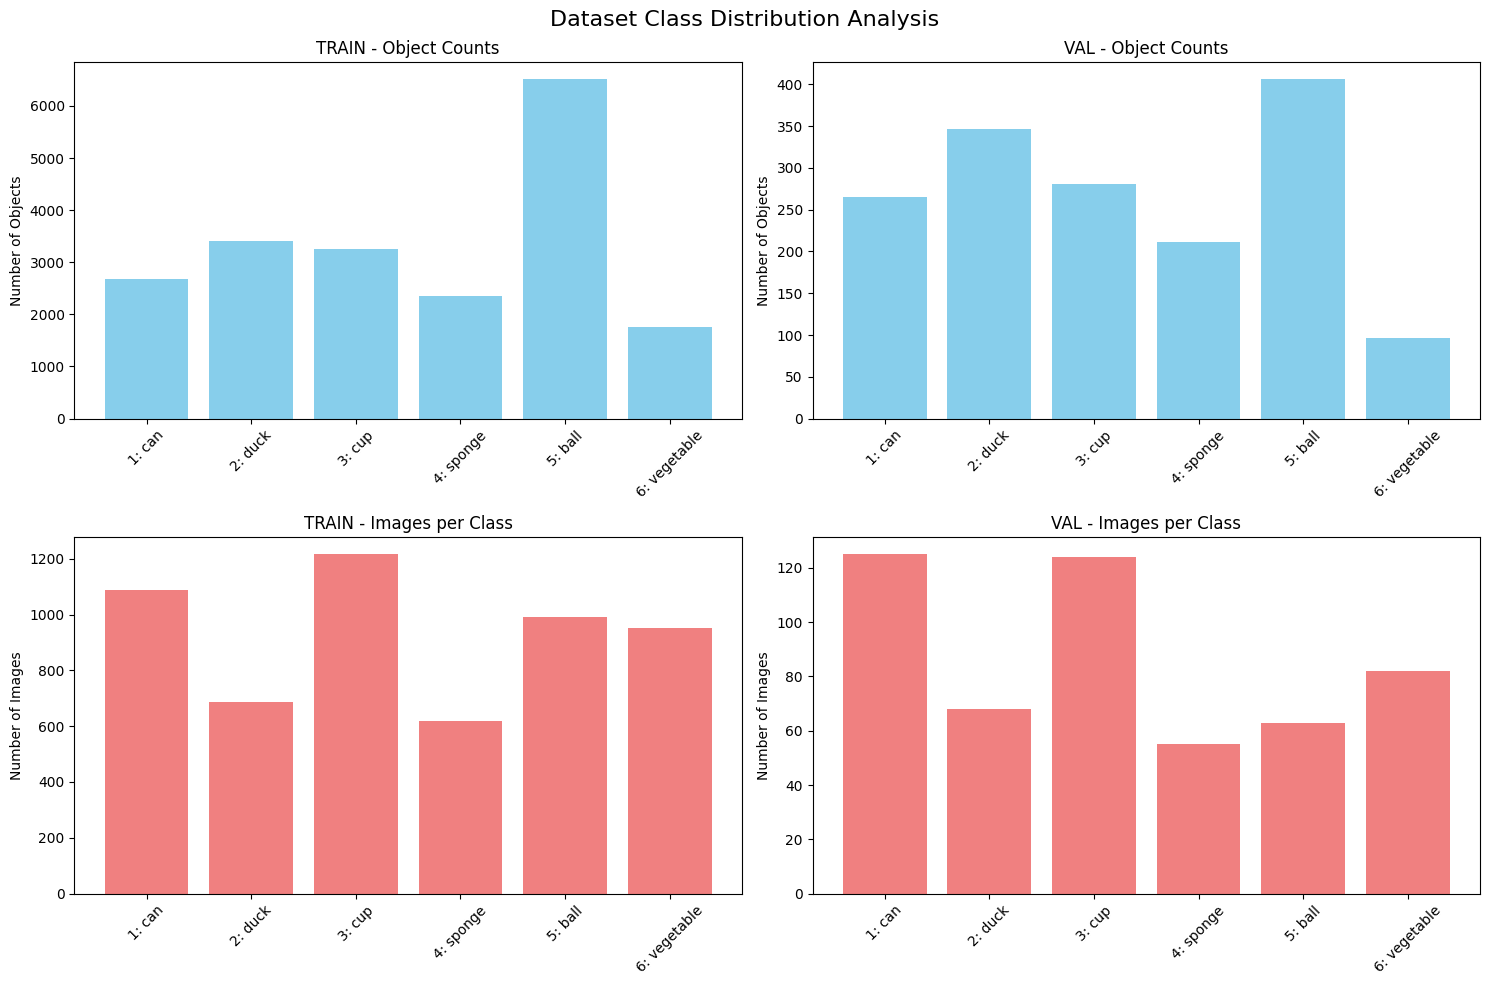


3. CLASS IMBALANCE ANALYSIS
------------------------------

TRAIN Split Class Percentages:
  1: can          2676 objects ( 13.4%)
  2: duck         3415 objects ( 17.1%)
  3: cup          3263 objects ( 16.3%)
  4: sponge       2352 objects ( 11.8%)
  5: ball         6511 objects ( 32.6%)
  6: vegetable    1755 objects (  8.8%)

VAL Split Class Percentages:
  1: can           265 objects ( 16.5%)
  2: duck          347 objects ( 21.6%)
  3: cup           281 objects ( 17.5%)
  4: sponge        211 objects ( 13.1%)
  5: ball          406 objects ( 25.3%)
  6: vegetable      97 objects (  6.0%)


In [3]:
# 2. Class Distribution Analysis
print("\n2. CLASS DISTRIBUTION")
print("-" * 30)

# Create summary table
class_data = []
for split in SPLITS:
    for cls_id, count in dataset_stats[split]['class_counts'].items():
        class_data.append({
            'Split': split,
            'Class ID': cls_id,
            'Class Name': CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f'Unknown_{cls_id}',
            'Object Count': count,
            'Image Count': len(dataset_stats[split]['images_per_class'][cls_id])
        })

df = pd.DataFrame(class_data)
print("\nClass distribution by split:")
print(df.pivot_table(index=['Class ID', 'Class Name'], 
                     columns='Split', 
                     values=['Object Count', 'Image Count'], 
                     fill_value=0))

# Plot class distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Class Distribution Analysis', fontsize=16)

for i, split in enumerate(SPLITS):
    # Object counts
    classes = []
    counts = []
    for cls_id in sorted(dataset_stats[split]['class_counts'].keys()):
        classes.append(f"{cls_id}: {CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f'Unknown_{cls_id}'}")
        counts.append(dataset_stats[split]['class_counts'][cls_id])
    
    axes[0, i].bar(classes, counts, color='skyblue')
    axes[0, i].set_title(f'{split.upper()} - Object Counts')
    axes[0, i].set_ylabel('Number of Objects')
    axes[0, i].tick_params(axis='x', rotation=45)
    
    # Images per class
    img_counts = [len(dataset_stats[split]['images_per_class'][cls_id]) 
                  for cls_id in sorted(dataset_stats[split]['class_counts'].keys())]
    
    axes[1, i].bar(classes, img_counts, color='lightcoral')
    axes[1, i].set_title(f'{split.upper()} - Images per Class')
    axes[1, i].set_ylabel('Number of Images')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show imbalance metrics
print("\n3. CLASS IMBALANCE ANALYSIS")
print("-" * 30)
for split in SPLITS:
    total_objects = sum(dataset_stats[split]['class_counts'].values())
    if total_objects > 0:
        print(f"\n{split.upper()} Split Class Percentages:")
        for cls_id in sorted(dataset_stats[split]['class_counts'].keys()):
            count = dataset_stats[split]['class_counts'][cls_id]
            percentage = (count / total_objects) * 100
            class_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f'Unknown_{cls_id}'
            print(f"  {cls_id}: {class_name:<12} {count:>4} objects ({percentage:>5.1f}%)")



4. OBJECTS PER IMAGE DISTRIBUTION
------------------------------


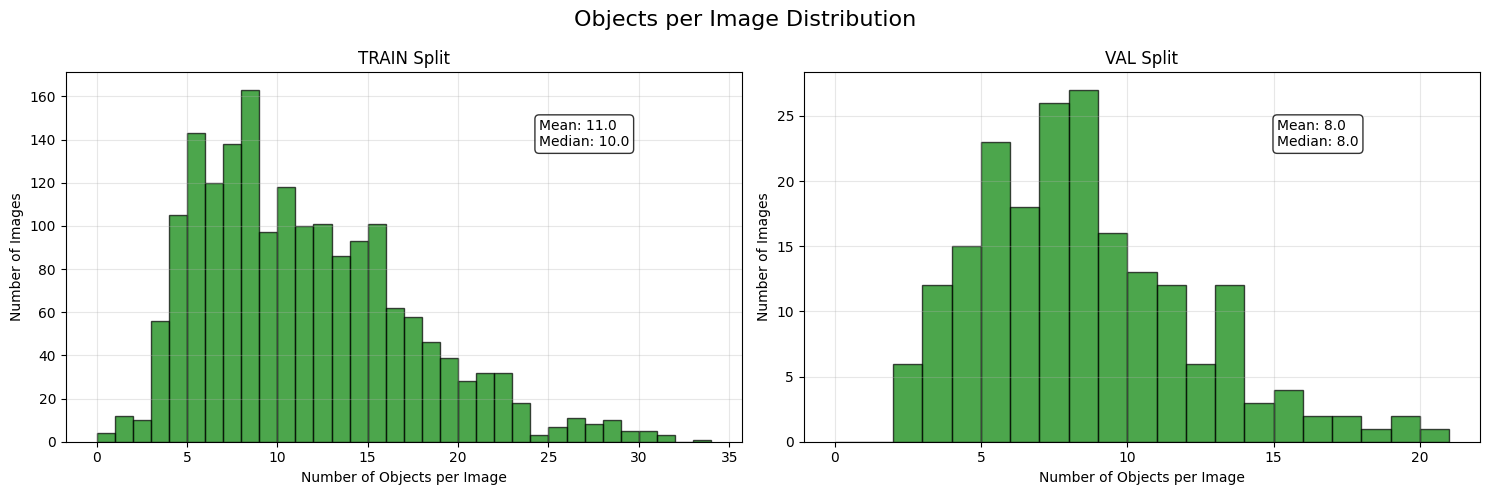


TRAIN Split Object Distribution:
  Mean objects per image: 11.00
  Median objects per image: 10.00
  Min objects per image: 0
  Max objects per image: 33
  Images with 0 objects: 4
  Images with 1+ objects: 1811

VAL Split Object Distribution:
  Mean objects per image: 8.00
  Median objects per image: 8.00
  Min objects per image: 2
  Max objects per image: 20
  Images with 0 objects: 0
  Images with 1+ objects: 201


In [4]:
# 4. Objects per Image Distribution
print("\n4. OBJECTS PER IMAGE DISTRIBUTION")
print("-" * 30)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Objects per Image Distribution', fontsize=16)

for i, split in enumerate(SPLITS):
    objects_per_img = dataset_stats[split]['objects_per_image']
    
    # Histogram
    axes[i].hist(objects_per_img, bins=range(max(objects_per_img) + 2), 
                 alpha=0.7, color='green', edgecolor='black')
    axes[i].set_title(f'{split.upper()} Split')
    axes[i].set_xlabel('Number of Objects per Image')
    axes[i].set_ylabel('Number of Images')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_obj = np.mean(objects_per_img)
    median_obj = np.median(objects_per_img)
    axes[i].text(0.7, 0.8, f'Mean: {mean_obj:.1f}\nMedian: {median_obj:.1f}', 
                 transform=axes[i].transAxes, bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Show detailed statistics
for split in SPLITS:
    objects_per_img = dataset_stats[split]['objects_per_image']
    print(f"\n{split.upper()} Split Object Distribution:")
    print(f"  Mean objects per image: {np.mean(objects_per_img):.2f}")
    print(f"  Median objects per image: {np.median(objects_per_img):.2f}")
    print(f"  Min objects per image: {min(objects_per_img)}")
    print(f"  Max objects per image: {max(objects_per_img)}")
    print(f"  Images with 0 objects: {objects_per_img.count(0)}")
    print(f"  Images with 1+ objects: {len([x for x in objects_per_img if x > 0])}")


In [5]:
# 5. Enhanced Visualization Functions
print("\n5. ENHANCED LABEL VISUALIZATION")
print("-" * 30)

def count_objects_in_label_file(label_path):
    """Count objects in a label file and return class breakdown"""
    if not os.path.exists(label_path):
        return 0, {}
    
    with open(label_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    
    class_counts = Counter()
    for line in lines:
        cls_id = int(line.split()[0])
        class_counts[cls_id] += 1
    
    return len(lines), dict(class_counts)

def draw_labels_enhanced(img, label_path, class_names):
    """Enhanced label drawing with better visibility and info"""
    img_h, img_w = img.shape[:2]
    total_objects, class_breakdown = count_objects_in_label_file(label_path)
    
    if total_objects == 0:
        # Draw "NO LABELS" text for empty images
        cv2.putText(img, "NO LABELS DETECTED", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        return img, total_objects, class_breakdown
    
    with open(label_path, 'r', encoding='utf-8') as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    
    # Use different colors for different classes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), 
              (255, 0, 255), (0, 255, 255), (128, 128, 128)]
    
    for line in lines:
        parts = line.split()
        cls = int(parts[0])
        cx, cy, w, h = map(float, parts[1:])
        x1 = int((cx - w/2.0) * img_w)
        y1 = int((cy - h/2.0) * img_h)
        x2 = int((cx + w/2.0) * img_w)
        y2 = int((cy + h/2.0) * img_h)
        
        name = class_names[cls] if cls < len(class_names) else str(cls)
        color = colors[cls % len(colors)]
        
        # Draw thicker rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        
        # Draw filled rectangle for text background
        text_size = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        cv2.rectangle(img, (x1, y1-text_size[1]-10), (x1+text_size[0]+10, y1), color, -1)
        
        # Draw text
        cv2.putText(img, name, (x1+5, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    
    return img, total_objects, class_breakdown

print("Enhanced visualization functions loaded.")



5. ENHANCED LABEL VISUALIZATION
------------------------------
Enhanced visualization functions loaded.



6. SAMPLE IMAGES WITH DETECTION DETAILS
------------------------------


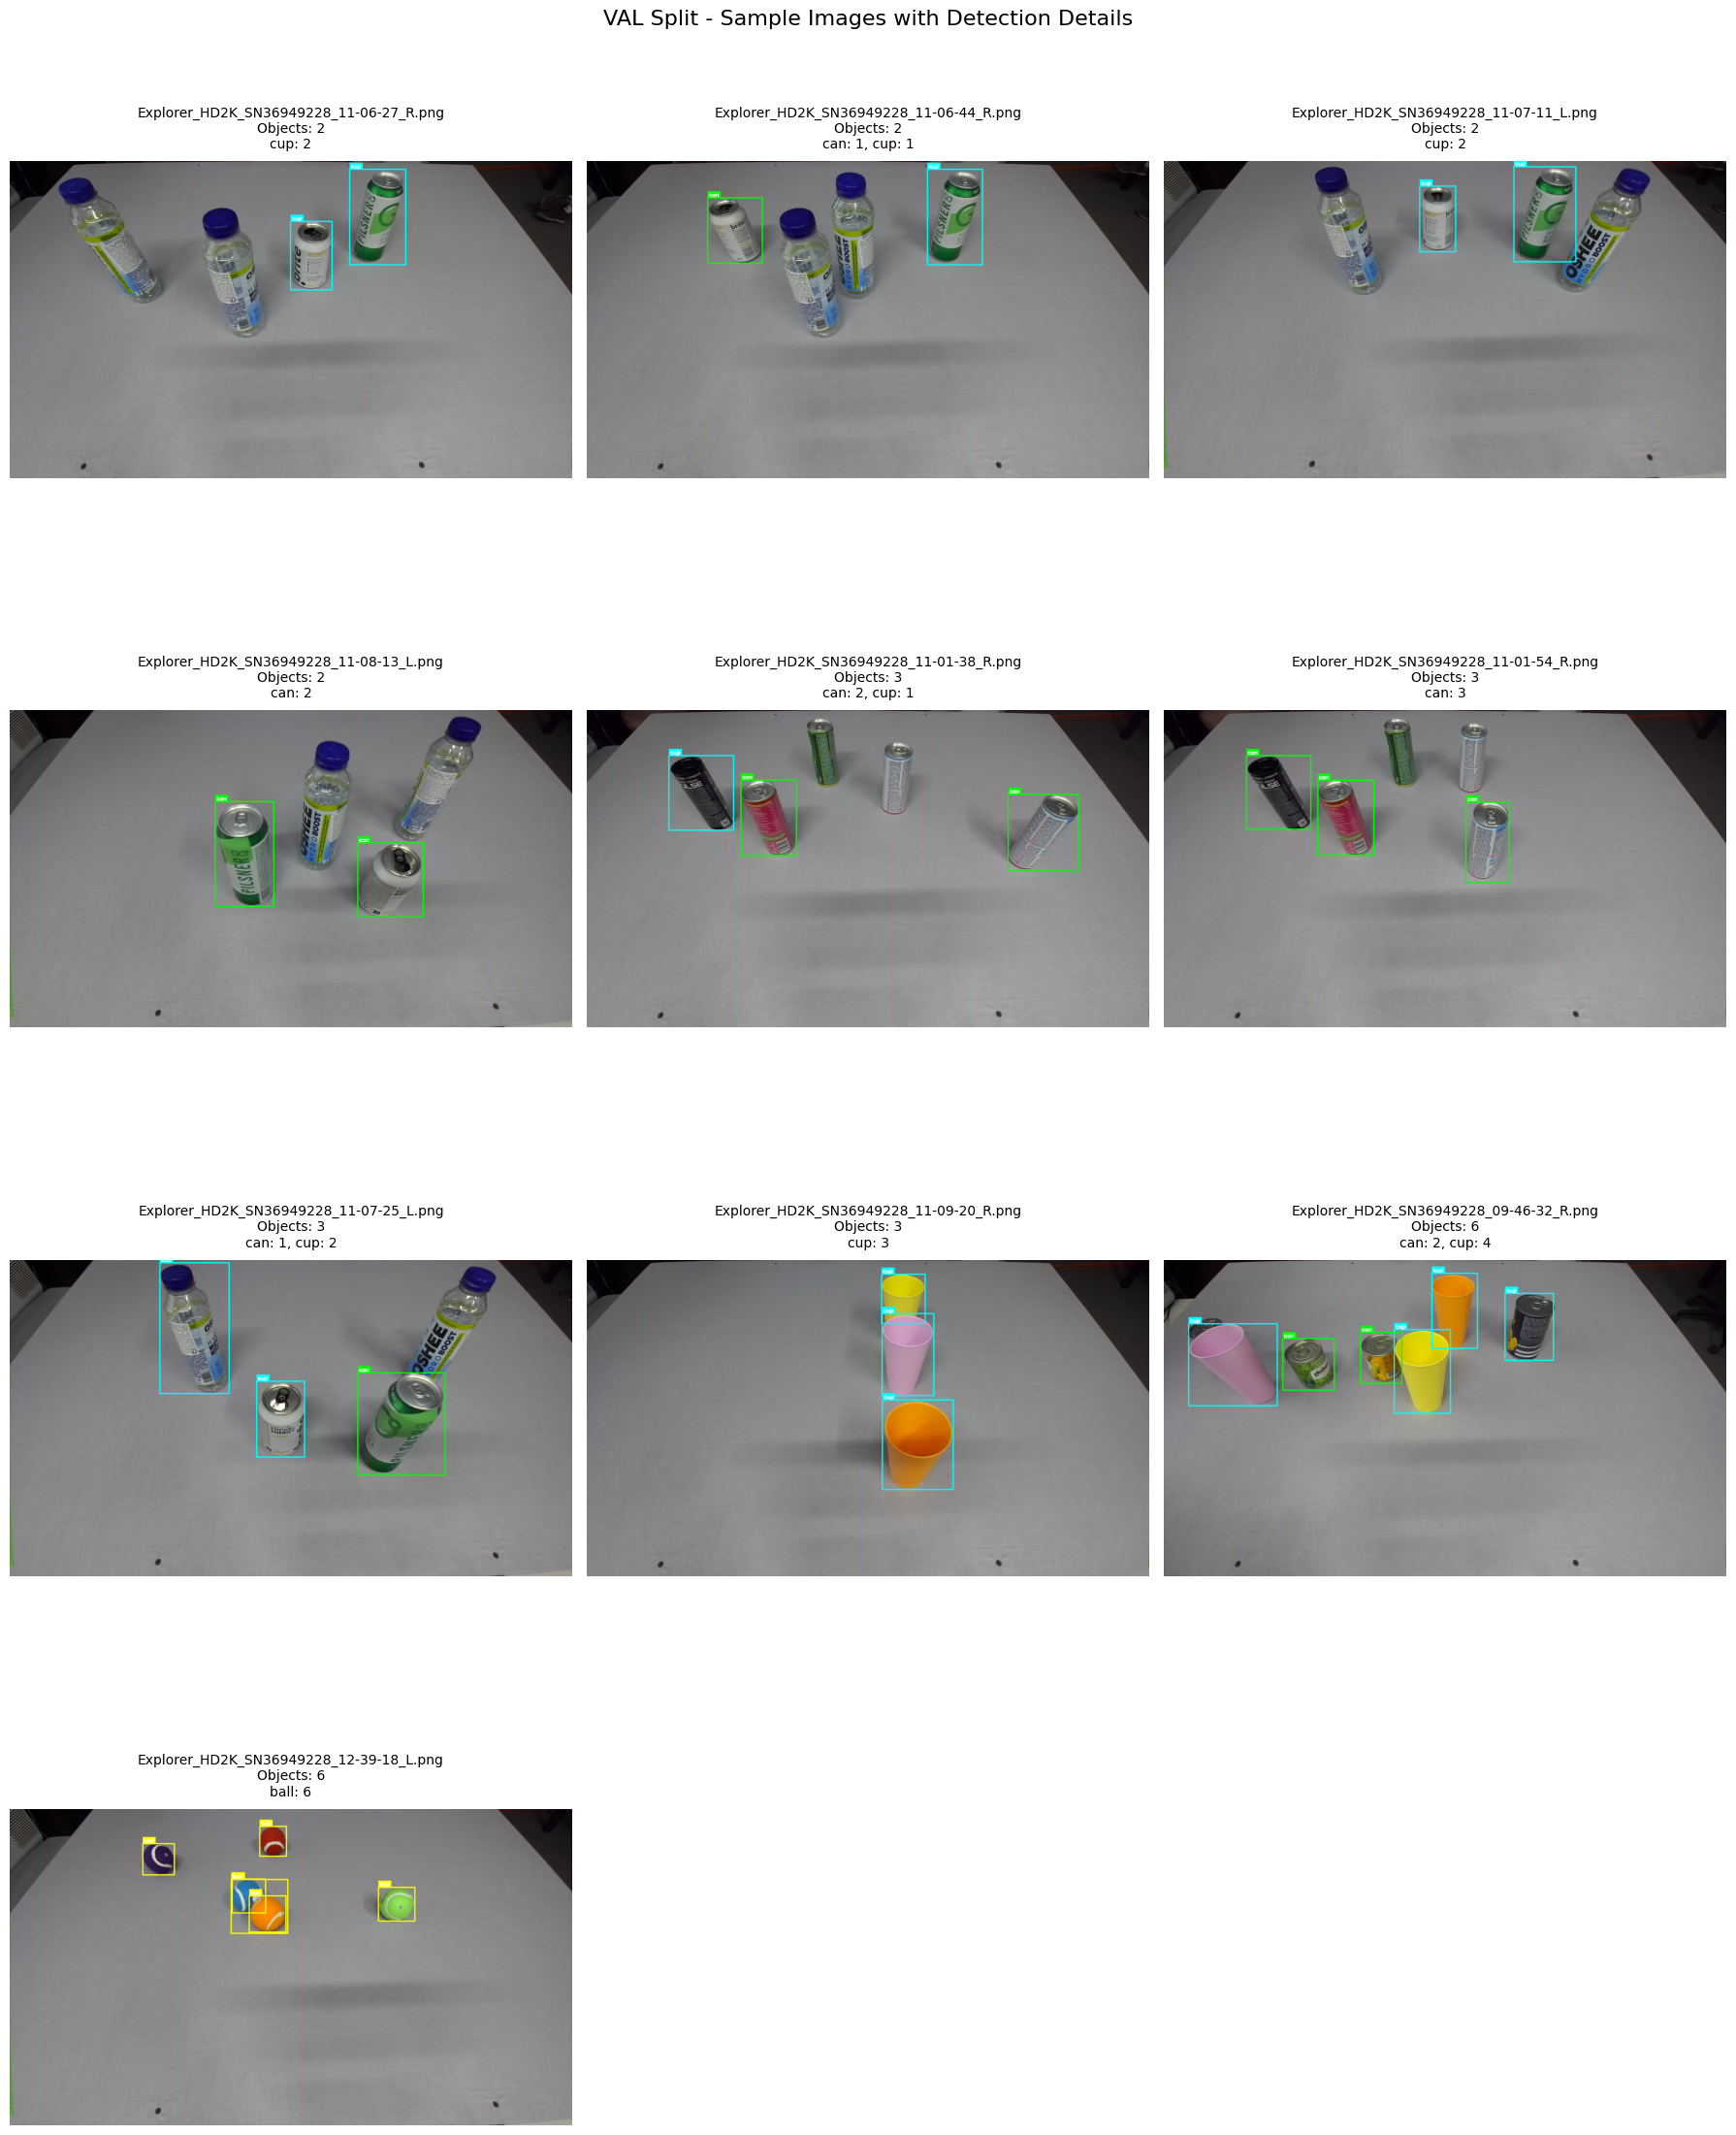

In [6]:
# 6. Sample Images with Detailed Information
print("\n6. SAMPLE IMAGES WITH DETECTION DETAILS")
print("-" * 30)

def show_images_with_details(split='val', max_images=12):
    """Show sample images with detailed detection information"""
    im_dir = os.path.join(DATASET_DIR, 'images', split)
    lbl_dir = os.path.join(DATASET_DIR, 'labels', split)
    
    all_imgs = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    
    # Select diverse images: some with many objects, some with few, some with none
    objects_per_img_with_paths = []
    for img_path in all_imgs:
        stem = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, f'{stem}.txt')
        obj_count, _ = count_objects_in_label_file(lbl_path)
        objects_per_img_with_paths.append((img_path, obj_count))
    
    # Sort by object count and select diverse samples
    objects_per_img_with_paths.sort(key=lambda x: x[1])
    
    # Select images: empty, low count, medium count, high count
    selected_imgs = []
    empty_imgs = [x for x in objects_per_img_with_paths if x[1] == 0]
    low_imgs = [x for x in objects_per_img_with_paths if 1 <= x[1] <= 2]
    med_imgs = [x for x in objects_per_img_with_paths if 3 <= x[1] <= 5]
    high_imgs = [x for x in objects_per_img_with_paths if x[1] > 5]
    
    # Take samples from each category
    for category, name in [(empty_imgs[:2], "empty"), (low_imgs[:4], "low"), 
                          (med_imgs[:4], "medium"), (high_imgs[:2], "high")]:
        selected_imgs.extend(category)
    
    selected_imgs = selected_imgs[:max_images]
    
    N = len(selected_imgs)
    cols = 3
    rows = int(np.ceil(N/cols))
    
    plt.figure(figsize=(18, 6*rows))
    
    for i, (img_path, expected_count) in enumerate(selected_imgs):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
            
        stem = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, f'{stem}.txt')
        
        img_draw, obj_count, class_breakdown = draw_labels_enhanced(img.copy(), lbl_path, CLASS_NAMES)
        img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
        
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img_rgb)
        
        # Create detailed title
        title = f"{os.path.basename(img_path)}\n"
        title += f"Objects: {obj_count}"
        
        if class_breakdown:
            breakdown_str = ", ".join([f"{CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f'C{cls_id}'}: {count}" 
                                     for cls_id, count in sorted(class_breakdown.items())])
            title += f"\n{breakdown_str}"
        
        ax.set_title(title, fontsize=10, pad=10)
        ax.axis('off')
    
    plt.suptitle(f'{split.upper()} Split - Sample Images with Detection Details', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show samples from validation set
show_images_with_details('val', 12)



7. TRAINING SET SAMPLES
------------------------------


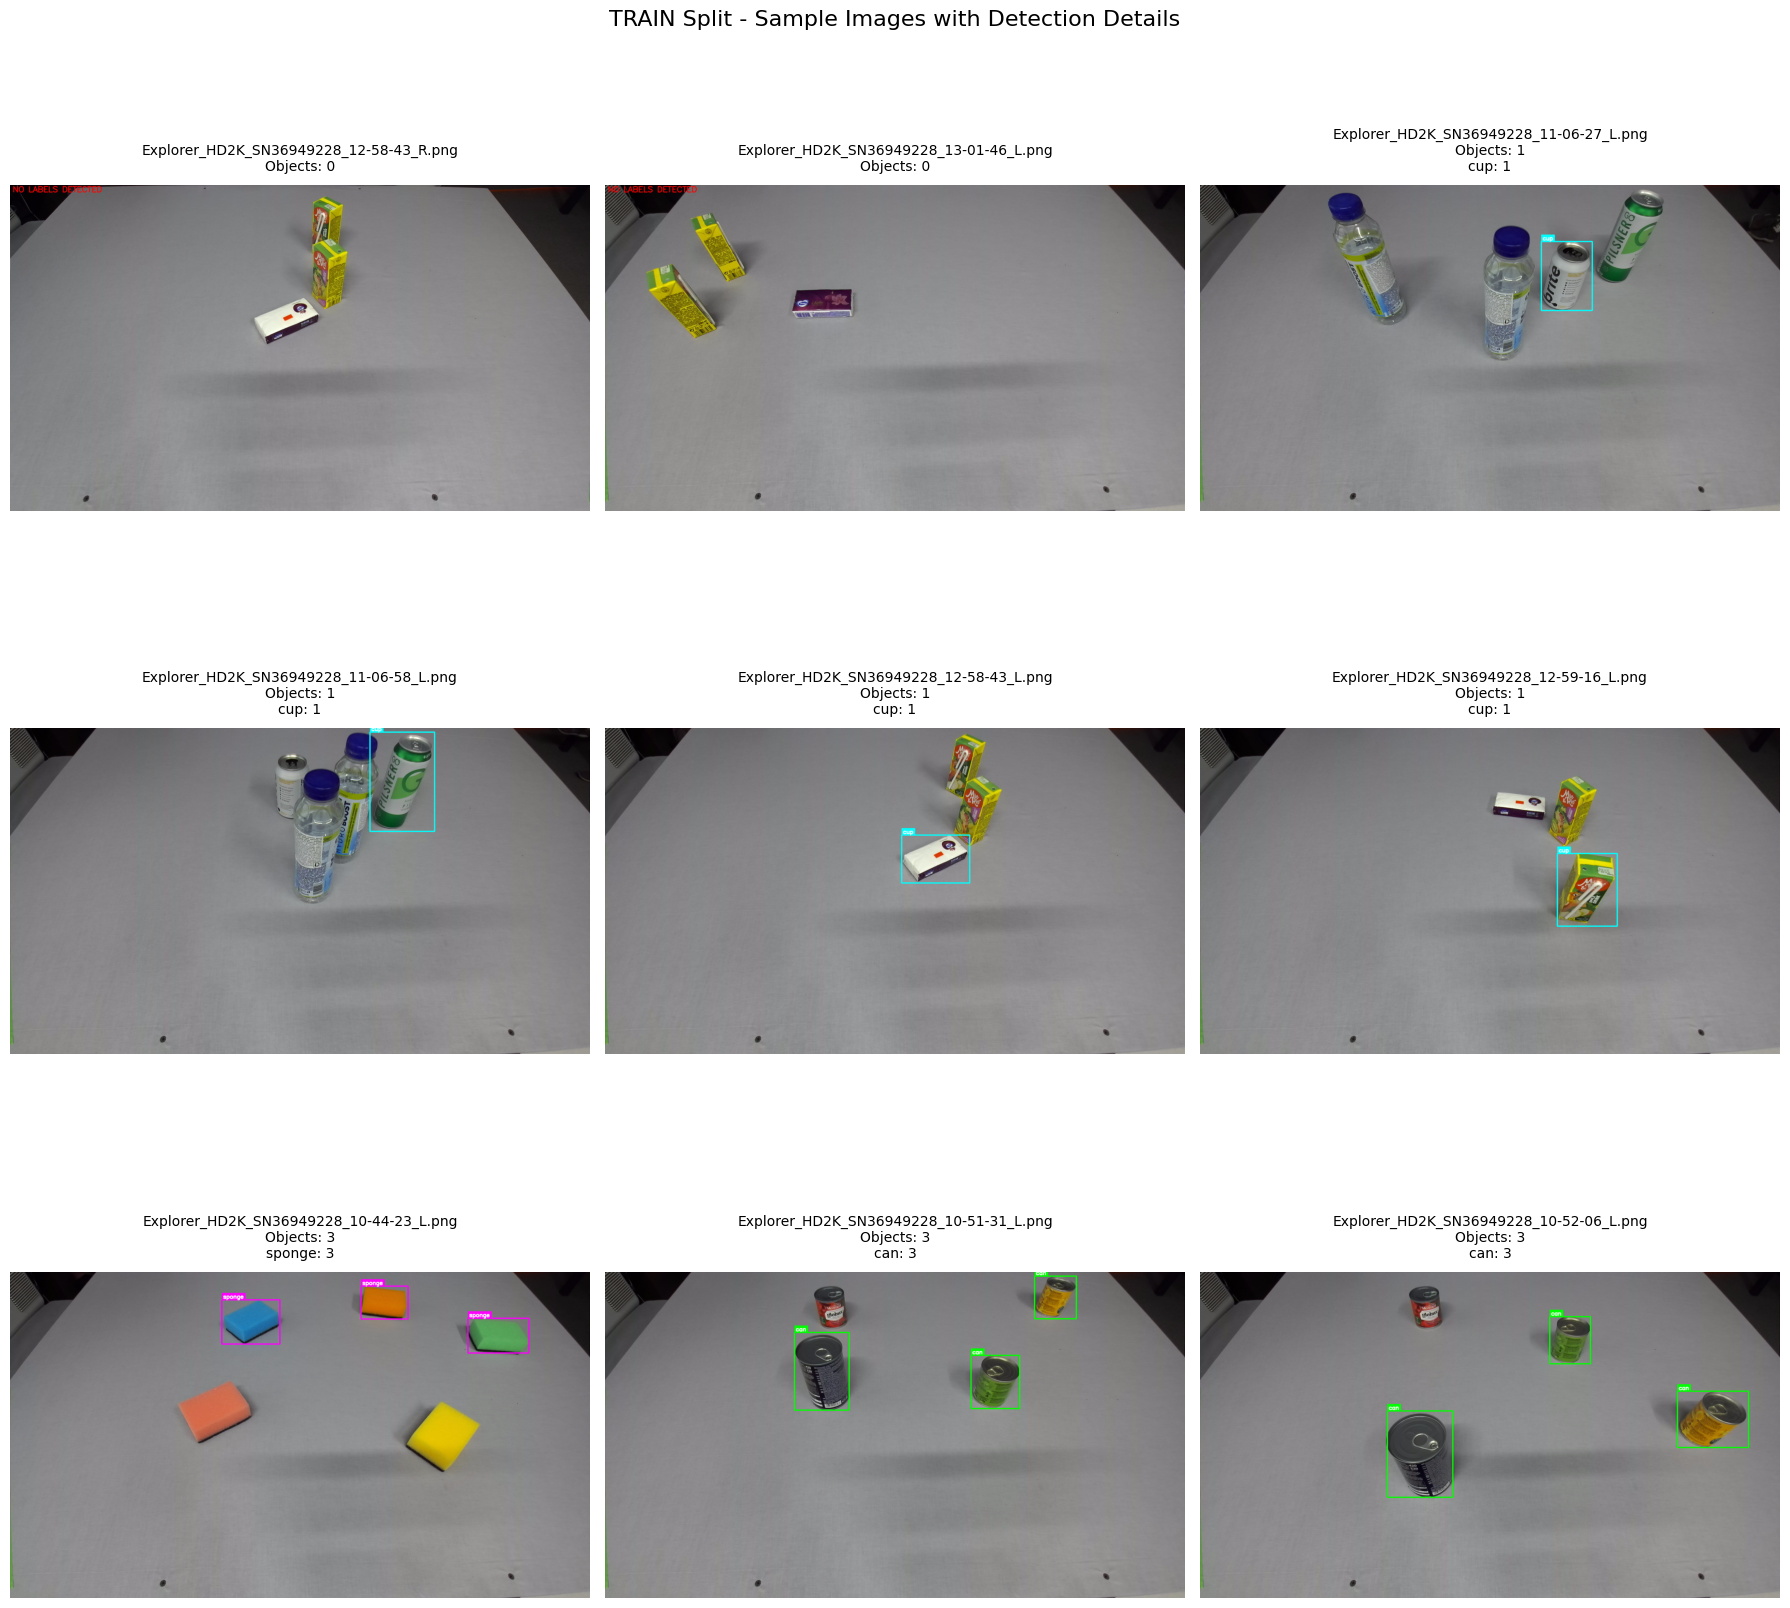

In [7]:
# 7. Training Set Samples (Optional)
print("\n7. TRAINING SET SAMPLES")
print("-" * 30)

# Show some training samples as well
show_images_with_details('train', 9)


In [9]:
# 8. Labeling Quality Assessment
print("\n8. LABELING QUALITY ASSESSMENT")
print("-" * 30)

def assess_labeling_quality():
    """Assess the quality and completeness of labeling"""
    
    for split in SPLITS:
        im_dir = os.path.join(DATASET_DIR, 'images', split)
        lbl_dir = os.path.join(DATASET_DIR, 'labels', split)
        
        images = glob.glob(os.path.join(im_dir, '*.png'))
        
        missing_labels = 0
        empty_labels = 0
        total_images = len(images)
        
        for img_path in images:
            stem = os.path.splitext(os.path.basename(img_path))[0]
            lbl_path = os.path.join(lbl_dir, f'{stem}.txt')
            
            if not os.path.exists(lbl_path):
                missing_labels += 1
            else:
                obj_count, _ = count_objects_in_label_file(lbl_path)
                if obj_count == 0:
                    empty_labels += 1
        
        labeled_images = total_images - missing_labels - empty_labels
        
        print(f"\n{split.upper()} Split Labeling Quality:")
        print(f"  Total images: {total_images}")
        print(f"  Images with labels: {labeled_images} ({labeled_images/total_images*100:.1f}%)")
        print(f"  Images with empty labels: {empty_labels} ({empty_labels/total_images*100:.1f}%)")
        print(f"  Images missing labels: {missing_labels} ({missing_labels/total_images*100:.1f}%)")
        
        if total_images > 0:
            coverage = (labeled_images / total_images) * 100
            if coverage >= 80:
                quality = "GOOD"
            elif coverage >= 60:
                quality = "FAIR"
            else:
                quality = "POOR"
            print(f"  Labeling coverage: {quality}")

assess_labeling_quality()

# Summary and recommendations
print("\n9. SUMMARY AND RECOMMENDATIONS")
print("-" * 30)

total_train_objects = sum(dataset_stats['train']['class_counts'].values()) if 'train' in dataset_stats else 0
total_val_objects = sum(dataset_stats['val']['class_counts'].values()) if 'val' in dataset_stats else 0

print(f"\nDataset Summary:")
print(f"  Total training objects: {total_train_objects}")
print(f"  Total validation objects: {total_val_objects}")

if total_train_objects > 0:
    # Find most and least common classes
    train_counts = dataset_stats['train']['class_counts']
    if train_counts:
        most_common_cls = max(train_counts.items(), key=lambda x: x[1])
        least_common_cls = min(train_counts.items(), key=lambda x: x[1])
        
        imbalance_ratio = most_common_cls[1] / least_common_cls[1] if least_common_cls[1] > 0 else float('inf')
        
        print(f"\nClass Imbalance:")
        print(f"  Most common: {CLASS_NAMES[most_common_cls[0]]} ({most_common_cls[1]} objects)")
        print(f"  Least common: {CLASS_NAMES[least_common_cls[0]]} ({least_common_cls[1]} objects)")
        print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
        
        print(f"\nRecommendations:")
        if imbalance_ratio > 10:
            print("  ⚠️  HIGH CLASS IMBALANCE detected!")
            print("  - Consider collecting more data for underrepresented classes")
            print("  - Use class weights during training")
            print("  - Apply data augmentation to minority classes")
        elif imbalance_ratio > 5:
            print("  ⚠️  Moderate class imbalance detected")
            print("  - Monitor training carefully for bias toward majority class")
        else:
            print("  ✅ Class distribution is reasonably balanced")
            
        if total_train_objects < 1000:
            print("  ⚠️  Small dataset size")
            print("  - Consider data augmentation")
            print("  - Use transfer learning")
        else:
            print("  ✅ Good dataset size for training")

print("\nAnalysis complete! 🎉")



8. LABELING QUALITY ASSESSMENT
------------------------------

TRAIN Split Labeling Quality:
  Total images: 1815
  Images with labels: 1811 (99.8%)
  Images with empty labels: 4 (0.2%)
  Images missing labels: 0 (0.0%)
  Labeling coverage: GOOD

VAL Split Labeling Quality:
  Total images: 201
  Images with labels: 201 (100.0%)
  Images with empty labels: 0 (0.0%)
  Images missing labels: 0 (0.0%)
  Labeling coverage: GOOD

9. SUMMARY AND RECOMMENDATIONS
------------------------------

Dataset Summary:
  Total training objects: 19972
  Total validation objects: 1607

Class Imbalance:
  Most common: ball (6511 objects)
  Least common: vegetable (1755 objects)
  Imbalance ratio: 3.7:1

Recommendations:
  ✅ Class distribution is reasonably balanced
  ✅ Good dataset size for training

Analysis complete! 🎉
